In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

import ibdloader
import baseheuristic as bh

rng = np.random.default_rng(2023)

datapath = "../datasets-genotek/"

In [8]:
#dataset 1: 
#only pure population samples and total ibd length and count between them

#CR_graph_rel.csv
#node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
#node_0,node_5,мордвины,мордвины,29.8172,4

#NC_graph_rel.csv 
#node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
#node_0,node_1,чеченцы,чеченцы,9.76537,1
#node_1,node_138,чеченцы,"кабардинцы,черкесы,адыгейцы",8.01344,1

dataset1fname = datapath+"NC_graph_rel.csv"
df = pd.read_csv(dataset1fname)
print(df)

pairs, weights, labels, labeldict, idxtranslator =\
ibdloader.load_pure( dataset1fname )



#data struсture conventions:
#node indices in datasets are not necessarily starting from 0 and consecutive 
#so they are enumerated in idxtranslator.
#for every idx the label of node with index idxtranslator[idx] is stored in labels[idx]
#length of both arrays labels and idxtranslator coincides with count of available nodes in the dataset  

#in graphs we store consecutive labels starting from 0
#it can be even subset of idxtranslator, so every graph must have its own gr_idxtranslator
#and possibly gr_labels

#example
#idxtranslator = [0 1 3 5 10]
#       labels = [2 0 2 0 2]
# pairs = [0 10 100]
#         [1 5 100]
#         [3 10 100]
#subset after removing node_3
#idxtranslator = [0 1 5 10]
#       labels = [2 0 0 2]

#lets not produce translated pairs
#just graphs with corresponding edges and nodes from 0 and consecutive


      node_id1  node_id2 label_id1 label_id2   ibd_sum  ibd_n
0       node_0    node_1   чеченцы   чеченцы   9.76537      1
1       node_0   node_13   чеченцы   чеченцы  26.49970      3
2       node_0   node_15   чеченцы   чеченцы   8.31678      1
3       node_0  node_594   чеченцы   чеченцы   8.64458      1
4       node_1    node_8   чеченцы   чеченцы   8.14209      1
...        ...       ...       ...       ...       ...    ...
6292  node_624  node_629    ингуши   осетины  11.24220      1
6293  node_624  node_630    ингуши   чеченцы  14.70900      2
6294  node_625  node_628   осетины   осетины   8.26460      1
6295  node_625  node_629   осетины   осетины   8.91348      1
6296  node_628  node_629   осетины   осетины  48.95750      6

[6297 rows x 6 columns]
Unique ids in ibd datafile: 614
OK: Ids are starting from 0
Label dictionary: {'чеченцы': 0, 'кабардинцы,черкесы,адыгейцы': 1, 'карачаевцы,балкарцы': 2, 'дагестанские народы': 3, 'ингуши': 4, 'кумыки': 5, 'ногайцы': 6, 'осетины': 7

# 1. построим распределение суммарных весов и количества ibd-сегментов

Distribution of ibd sum
Total values: 6297 min: [8.00151] max: [286.517] ave: 24.5138846403049
filtered values: 5699 min: 8.00151 max: 49.9729 ave: 18.210090117564487


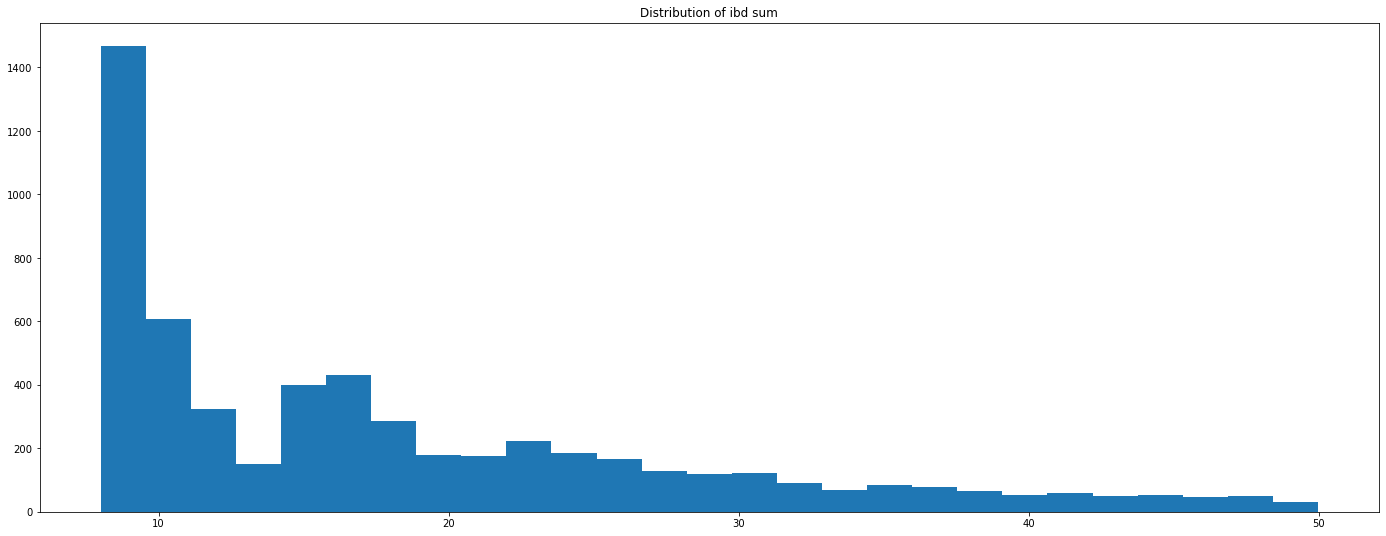

Distribution of ibd count
Total values: 6297 min: 1 max: 27 ave: 2.593139590281086
filtered values: 6127 min: 1 max: 9 ave: 2.3027582830096294


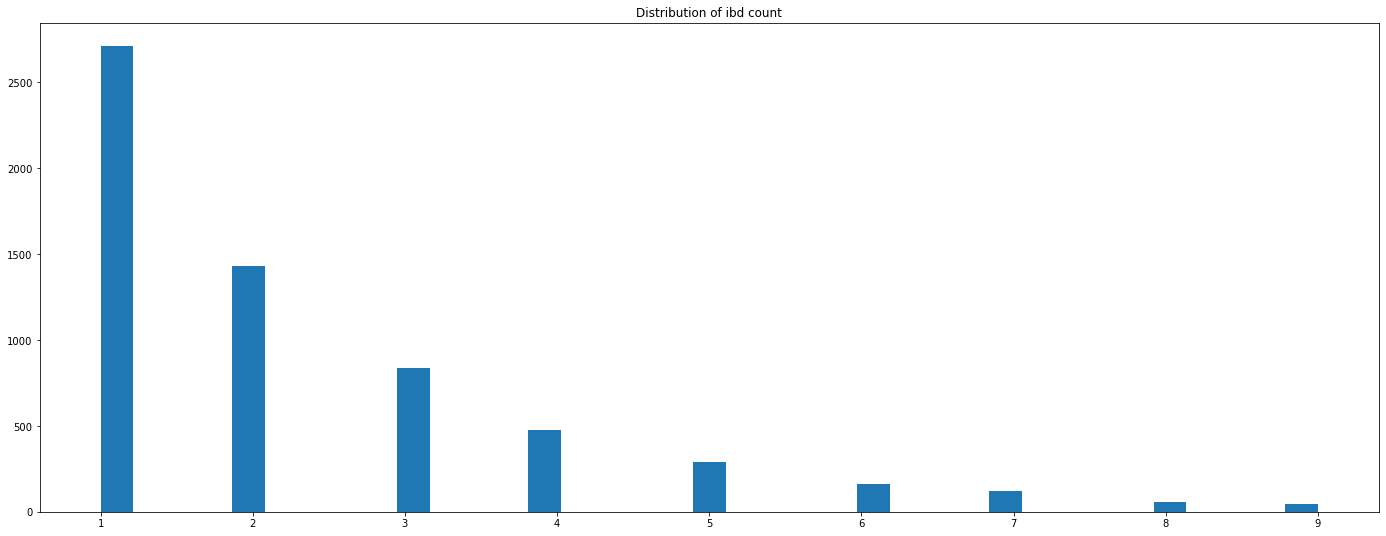

In [9]:
bh.plot_distribution(weights, 50, "Distribution of ibd sum")
bh.plot_distribution(pairs[:,2], 10, "Distribution of ibd count")

# 2. Распределение весов внутри и между классами

In [10]:
#change plot_distr to true to plot distributions
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
graphdata = bh.composegraphs(pairs, weights, labels, labeldict, idxtranslator)
ncls = graphdata[0]['nodeclasses']
grph = graphdata[0]['graph']
trns = graphdata[0]['translation']

bh.checkpartition(grph, ncls, None, None, details=True, trns=trns)

weimatrix, countmatrix, distrs = bh.getweightandcountmatrices(grph, ncls, labeldict, plot_distr=False)

Partition is ok, no dangling nodes found


In [ ]:
for dst in distrs:
    print(dst)

In [ ]:
#Optional: fit distributions to popular pdf curves
#distributions here are of ibd sum from individual of one class to the whole another class, so they are
#not symmetric, e.g. distribution from mordvins to belarussians is not the same as distribution from belarussians to mordvins

#it is isteresting to see symmetric distribution as well (distribution on ibd-sum of one link between two classes)
#or distribution of link count from individual of one population to the whole another population (also non-symmetrical)

#total distribution of link count between two individuals is not informative (almost constant 1)


#dist_names = ['alpha', 'gamma', 'norm']
dist_names = ['gamma', 'norm']
for label in distrs:
    #label = "южные-русские"
    data = distrs[label]["data"]
    threshold = distrs[label]["threshold"]
    if threshold is None:
        threshold = 1000
    bins = distrs[label]["bins"]
    bh.plot_and_fit_distribution(data, threshold, bins, f"Distribution of ibd sum for {label}", dist_names)

# 3. Матрица сумм весов внутри и между классами

чеченцы: 95
кабардинцы,черкесы,адыгейцы: 148
карачаевцы,балкарцы: 86
дагестанские народы: 134
ингуши: 52
кумыки: 18
ногайцы: 29
осетины: 52


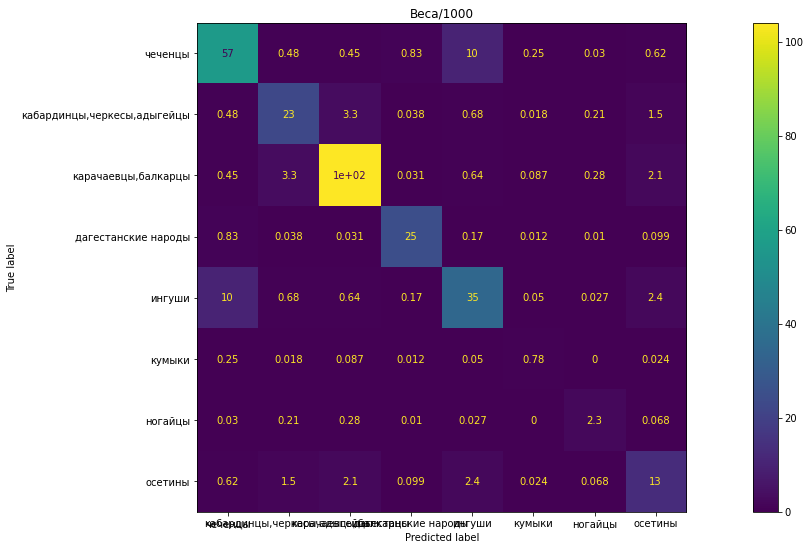

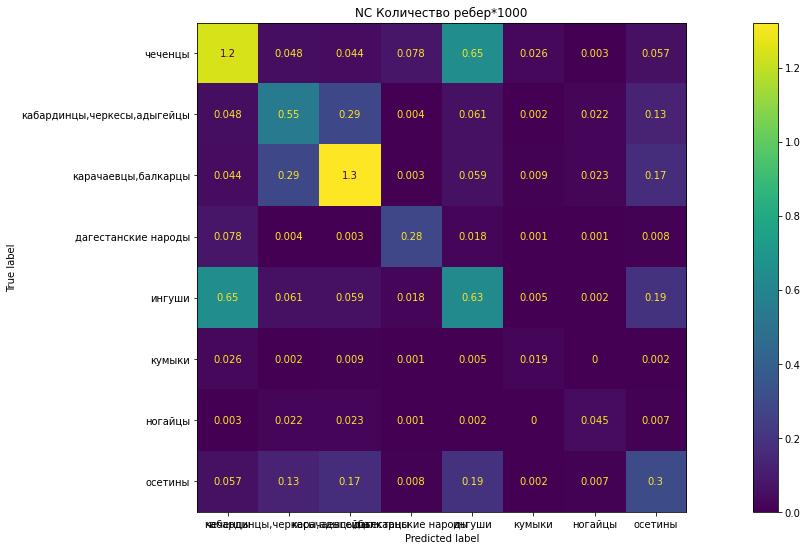

In [13]:
#check total ibd sum between classes
for label in ncls:
    print (f"{label}: {ncls[label].shape[0]}")
    
# в тысячах
cm_display = ConfusionMatrixDisplay(weimatrix/1000, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("Веса/1000")
plt.show()
cm_display = ConfusionMatrixDisplay(countmatrix/1000, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("NC Количество ребер*1000")
plt.show()

# Классификация

Построим матрицы ошибок по:

1. количеству ребер до известных классов
2. числу ребер на количество членов класса
3. количеству ibd-сегментов до известных классов
4. самому длинный сегмент
5. весу на ребро
6. суммарному весу ребер до известных классов



In [7]:
start = time.time()
featuredict = bh.getfeatures(grph, grph.nodes, ncls, labeldict, pairs, trns )
print(f"features collected in {time.time()-start} seconds\n")

features collected in 0.37107181549072266 seconds



Число ребер до класса: Accuracy: 0.9267, correct: 569, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.79      1.00      0.88        95
кабардинцы,черкесы,адыгейцы       0.99      0.91      0.95       148
        карачаевцы,балкарцы       0.87      1.00      0.93        86
        дагестанские народы       1.00      0.90      0.94       134
                     ингуши       0.94      0.98      0.96        52
                     кумыки       1.00      0.50      0.67        18
                    ногайцы       1.00      0.86      0.93        29
                    осетины       0.96      0.92      0.94        52

                   accuracy                           0.93       614
                  macro avg       0.94      0.88      0.90       614
               weighted avg       0.94      0.93      0.93       614



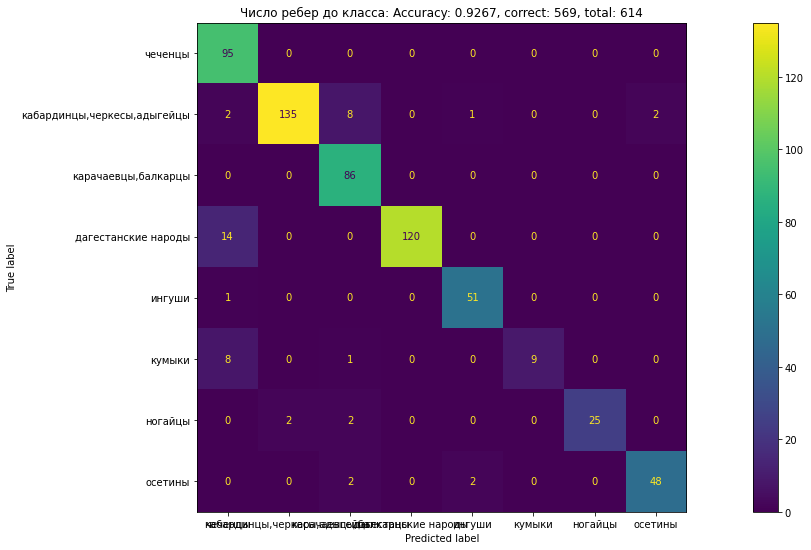

Число ребер до класса на размер класса: Accuracy: 0.8795, correct: 540, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.88      0.96      0.92        95
кабардинцы,черкесы,адыгейцы       1.00      0.71      0.83       148
        карачаевцы,балкарцы       0.80      0.95      0.87        86
        дагестанские народы       1.00      0.87      0.93       134
                     ингуши       0.76      1.00      0.87        52
                     кумыки       0.89      0.89      0.89        18
                    ногайцы       0.88      0.97      0.92        29
                    осетины       0.72      0.96      0.83        52

                   accuracy                           0.88       614
                  macro avg       0.87      0.91      0.88       614
               weighted avg       0.90      0.88      0.88       614



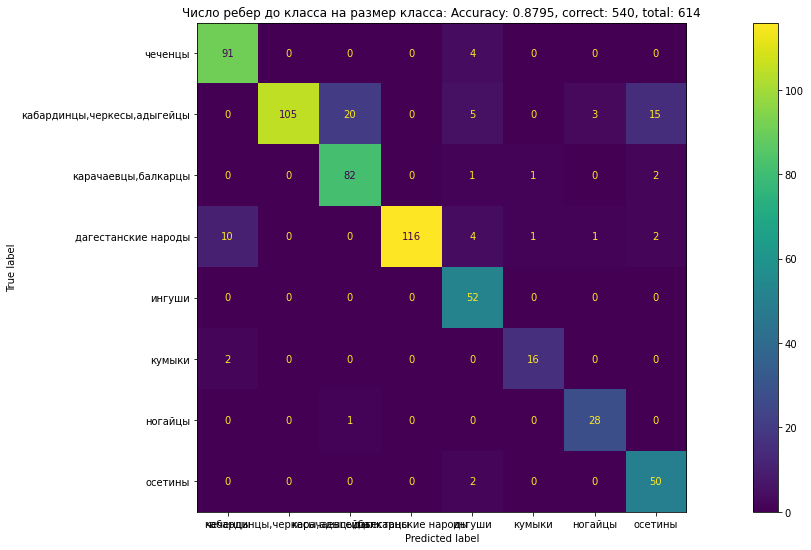

Число ребер до класса с учетом сегментов: Accuracy: 0.9463, correct: 581, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.83      1.00      0.90        95
кабардинцы,черкесы,адыгейцы       0.99      0.93      0.96       148
        карачаевцы,балкарцы       0.91      0.99      0.95        86
        дагестанские народы       1.00      0.90      0.95       134
                     ингуши       0.96      1.00      0.98        52
                     кумыки       1.00      0.72      0.84        18
                    ногайцы       1.00      0.90      0.95        29
                    осетины       0.98      0.98      0.98        52

                   accuracy                           0.95       614
                  macro avg       0.96      0.93      0.94       614
               weighted avg       0.95      0.95      0.95       614



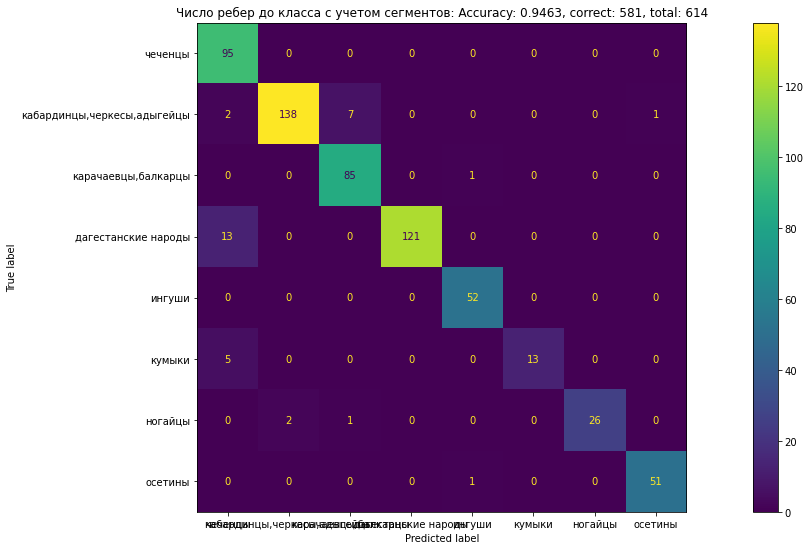

Самый длинный сегмент: Accuracy: 0.9218, correct: 566, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.86      0.97      0.91        95
кабардинцы,черкесы,адыгейцы       0.98      0.85      0.91       148
        карачаевцы,балкарцы       0.85      0.97      0.90        86
        дагестанские народы       1.00      0.93      0.96       134
                     ингуши       0.84      0.94      0.89        52
                     кумыки       1.00      0.83      0.91        18
                    ногайцы       1.00      0.90      0.95        29
                    осетины       0.88      0.98      0.93        52

                   accuracy                           0.92       614
                  macro avg       0.93      0.92      0.92       614
               weighted avg       0.93      0.92      0.92       614



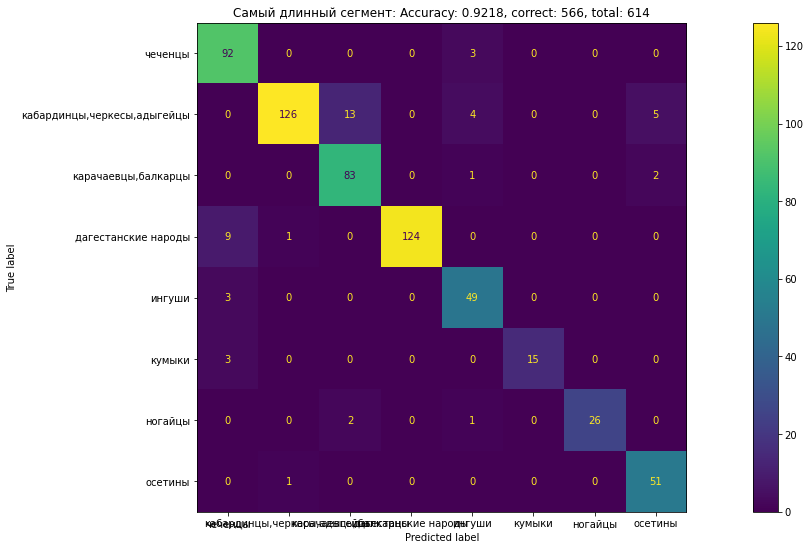

Сумма IBD до класса: Accuracy: 0.9511, correct: 584, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.88      1.00      0.94        95
кабардинцы,черкесы,адыгейцы       0.99      0.92      0.95       148
        карачаевцы,балкарцы       0.90      0.97      0.93        86
        дагестанские народы       1.00      0.92      0.96       134
                     ингуши       0.95      1.00      0.97        52
                     кумыки       1.00      0.83      0.91        18
                    ногайцы       1.00      1.00      1.00        29
                    осетины       0.93      0.98      0.95        52

                   accuracy                           0.95       614
                  macro avg       0.96      0.95      0.95       614
               weighted avg       0.96      0.95      0.95       614



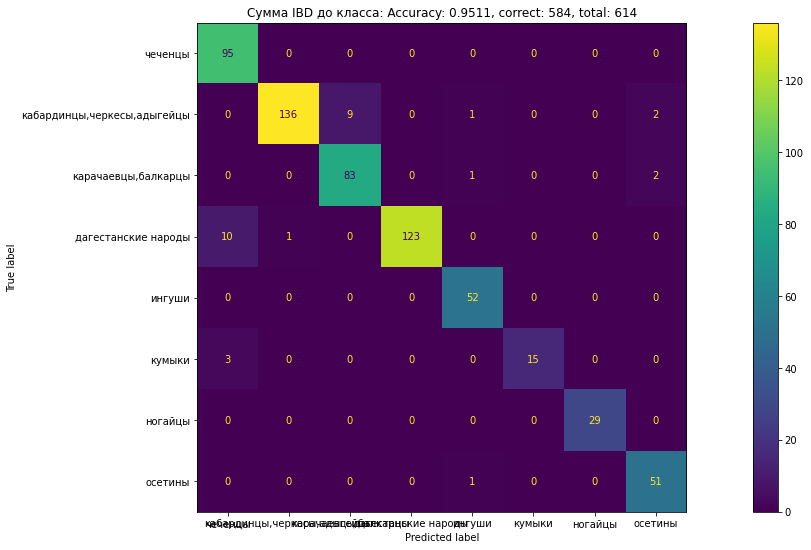

Сумма IBD до класса на ребро: Accuracy: 0.9023, correct: 554, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.86      0.97      0.91        95
кабардинцы,черкесы,адыгейцы       0.95      0.82      0.88       148
        карачаевцы,балкарцы       0.84      0.94      0.89        86
        дагестанские народы       1.00      0.91      0.95       134
                     ингуши       0.79      0.96      0.87        52
                     кумыки       1.00      0.89      0.94        18
                    ногайцы       0.96      0.86      0.91        29
                    осетины       0.84      0.90      0.87        52

                   accuracy                           0.90       614
                  macro avg       0.91      0.91      0.90       614
               weighted avg       0.91      0.90      0.90       614



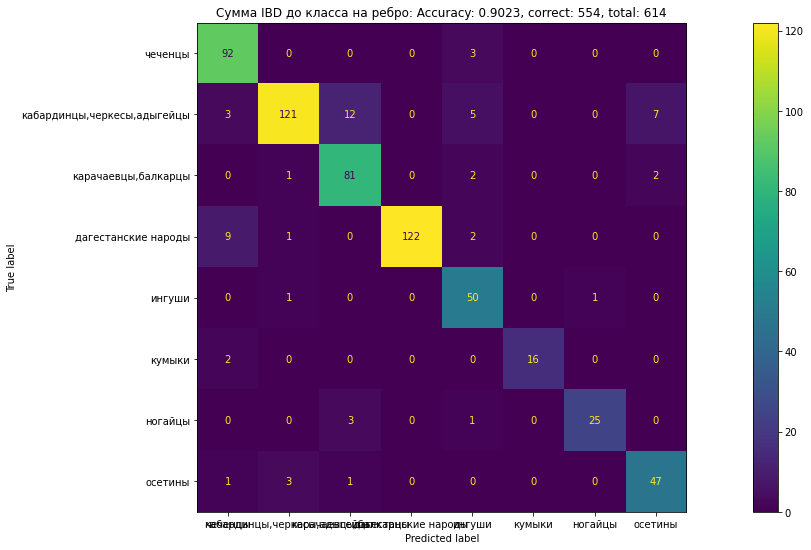

In [8]:
simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    title = featuredict[feature]["comment"]
    bh.show_prediction(labels, prediction, labeldict.keys(), title)

# Наиболее уверенный классификатор

Классификация наиболее уверенным классификатором.: Accuracy: 0.9446, correct: 580, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.88      1.00      0.94        95
кабардинцы,черкесы,адыгейцы       0.99      0.91      0.94       148
        карачаевцы,балкарцы       0.88      0.97      0.92        86
        дагестанские народы       1.00      0.92      0.96       134
                     ингуши       0.91      1.00      0.95        52
                     кумыки       1.00      0.83      0.91        18
                    ногайцы       1.00      0.93      0.96        29
                    осетины       0.94      0.98      0.96        52

                   accuracy                           0.94       614
                  macro avg       0.95      0.94      0.94       614
               weighted avg       0.95      0.94      0.94       614



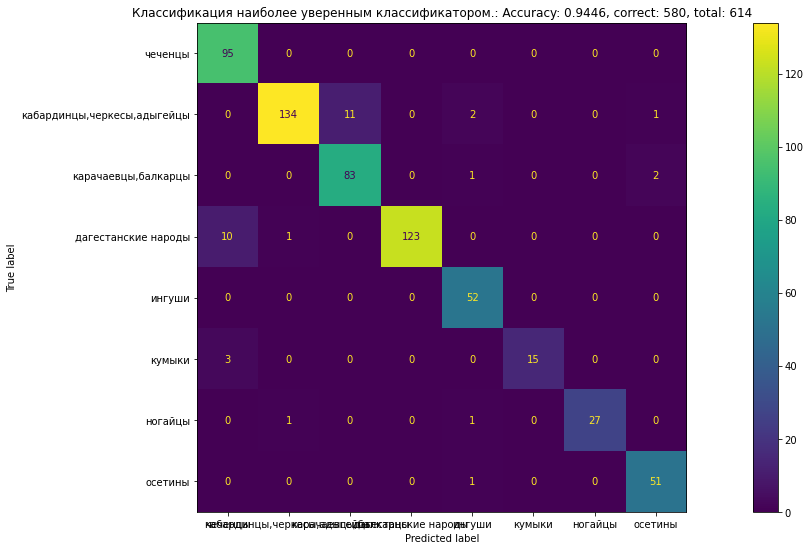

In [9]:
#наиболее уверенный классификатор среди нескольких с весами
#nodecount = labels.shape[0]
#labelcount = len(labeldict)


featureweights = {
    "SegmentCount": 0,
    "SegmentCountPerClassize": 0,
    "SegmentCountWMult": 1,
    "LongestIbd": 1,
    "IbdSum": 1,
    "IbdSumPerEdge": 0
}

#this is useful for the case where no second-best class is available, so several classifiers have infinite confidence
featurepriority = [
    "IbdSum",
    "LongestIbd",
    "SegmentCountWMult",
    "SegmentCountPerClassize",    
    "SegmentCount",    
    "IbdSumPerEdge"]

mostconfident = bh.get_most_confident_prediction(featuredict, featureweights, featurepriority)
bh.show_prediction(labels, mostconfident, labeldict.keys(), "Классификация наиболее уверенным классификатором.")

# Простой перебор для поиска наилучшей комбинации весов

{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 1, 'SegmentCountWMult': 0, 'SegmentCountPerClassize': 0.5, 'SegmentCount': 0} 0.9495114006514658
Классификация наиболее уверенным классификатором.: Accuracy: 0.9495, correct: 583, total: 614
                             precision    recall  f1-score   support

                    чеченцы       0.90      1.00      0.95        95
кабардинцы,черкесы,адыгейцы       0.99      0.91      0.95       148
        карачаевцы,балкарцы       0.89      0.97      0.93        86
        дагестанские народы       1.00      0.92      0.96       134
                     ингуши       0.93      1.00      0.96        52
                     кумыки       1.00      0.89      0.94        18
                    ногайцы       1.00      1.00      1.00        29
                    осетины       0.91      0.98      0.94        52

                   accuracy                           0.95       614
                  macro avg       0.95      0.96      0.95       61

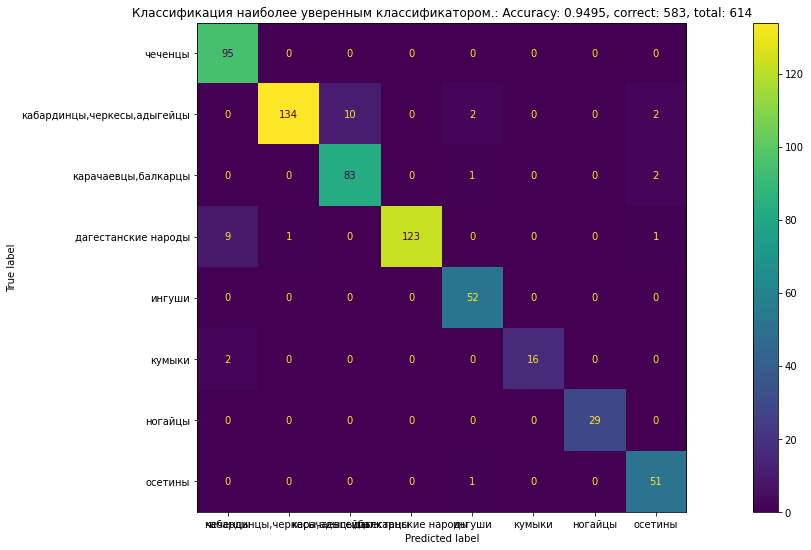

In [10]:
#search for the best parameter combination
#may take hours
featureweightrange = {
    "SegmentCount": [0],
    "SegmentCountPerClassize": np.arange(0.5,1.5,0.1),
    "SegmentCountWMult": [0],    
    "LongestIbd": [1],
    "IbdSum": np.arange(0.1,1.5,0.1),    
    "IbdSumPerEdge": [0]
}

bestweights, bestaccuracy = bh.search_best_weights(featuredict, featureweightrange, featurepriority, labels, trainnodes = None, show_intermediate = False)
print(bestweights, bestaccuracy)
mostconfident = bh.get_most_confident_prediction(featuredict, bestweights, featurepriority)
bh.show_prediction(labels, mostconfident, labeldict.keys(), "Классификация наиболее уверенным классификатором.")

# Разбиение на "тренировочную", "валидационную" и "тестовую" части

Разделим каждый класс train:val:test = 60:20:20, веса выберем по "тренировочной"+"валидационной" выборке, метрики посчитаем по "тестовой" 

train|val|test distribution
чеченцы : 57 : 19 : 19
кабардинцы,черкесы,адыгейцы : 89 : 29 : 30
карачаевцы,балкарцы : 52 : 17 : 17
дагестанские народы : 80 : 27 : 27
ингуши : 31 : 11 : 10
кумыки : 11 : 3 : 4
ногайцы : 17 : 6 : 6
осетины : 31 : 11 : 10
train nodes: 368
val nodes: 123
test nodes: 123
Dangling train node from population кабардинцы,черкесы,адыгейцы: 196, original id:199
Dangling train node from population кабардинцы,черкесы,адыгейцы: 192, original id:195
Dangling train node from population дагестанские народы: 152, original id:152
Dangling train node from population дагестанские народы: 157, original id:157
Dangling train node from population дагестанские народы: 149, original id:149
Dangling train node from population кумыки: 437, original id:445
Dangling train node from population ногайцы: 222, original id:227
Dangling val node from population кабардинцы,черкесы,адыгейцы: 195, original id:198
Dangling val node from population дагестанские народы: 155, original id:155
Bad p

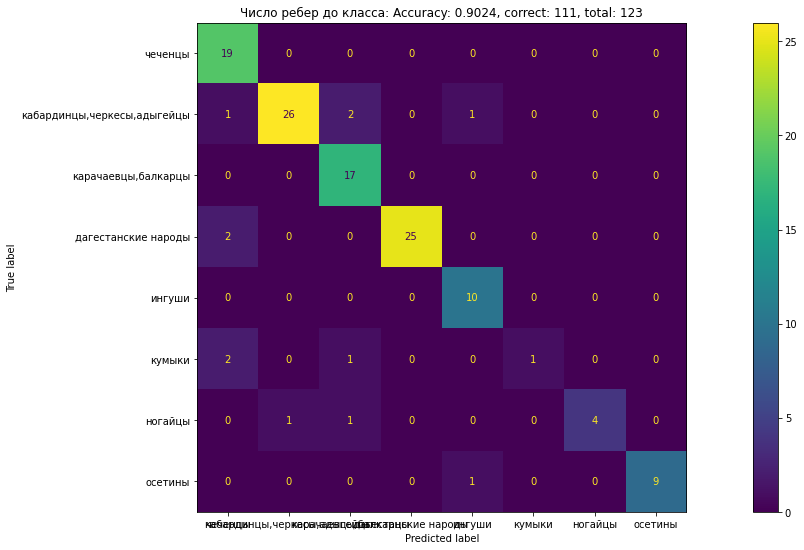

Число ребер до класса на размер класса: Accuracy: 0.8293, correct: 102, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.94      0.84      0.89        19
кабардинцы,черкесы,адыгейцы       1.00      0.63      0.78        30
        карачаевцы,балкарцы       0.75      0.88      0.81        17
        дагестанские народы       1.00      0.85      0.92        27
                     ингуши       0.50      1.00      0.67        10
                     кумыки       0.80      1.00      0.89         4
                    ногайцы       1.00      1.00      1.00         6
                    осетины       0.69      0.90      0.78        10

                   accuracy                           0.83       123
                  macro avg       0.84      0.89      0.84       123
               weighted avg       0.88      0.83      0.84       123



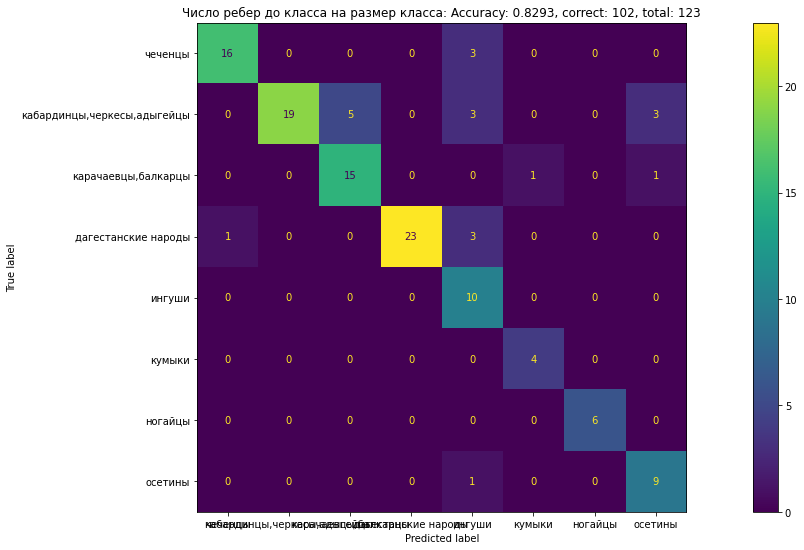

Число ребер до класса с учетом сегментов: Accuracy: 0.9187, correct: 113, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.79      1.00      0.88        19
кабардинцы,черкесы,адыгейцы       0.96      0.87      0.91        30
        карачаевцы,балкарцы       0.85      1.00      0.92        17
        дагестанские народы       1.00      0.93      0.96        27
                     ингуши       1.00      1.00      1.00        10
                     кумыки       1.00      0.25      0.40         4
                    ногайцы       1.00      0.83      0.91         6
                    осетины       0.91      1.00      0.95        10

                   accuracy                           0.92       123
                  macro avg       0.94      0.86      0.87       123
               weighted avg       0.93      0.92      0.91       123



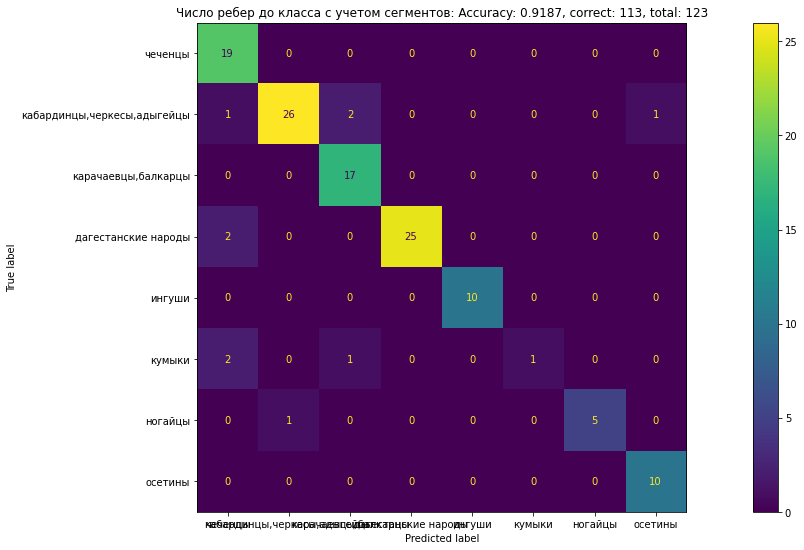

Самый длинный сегмент: Accuracy: 0.9187, correct: 113, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.86      0.95      0.90        19
кабардинцы,черкесы,адыгейцы       1.00      0.87      0.93        30
        карачаевцы,балкарцы       0.84      0.94      0.89        17
        дагестанские народы       1.00      0.93      0.96        27
                     ингуши       0.83      1.00      0.91        10
                     кумыки       1.00      1.00      1.00         4
                    ногайцы       1.00      0.83      0.91         6
                    осетины       0.82      0.90      0.86        10

                   accuracy                           0.92       123
                  macro avg       0.92      0.93      0.92       123
               weighted avg       0.93      0.92      0.92       123



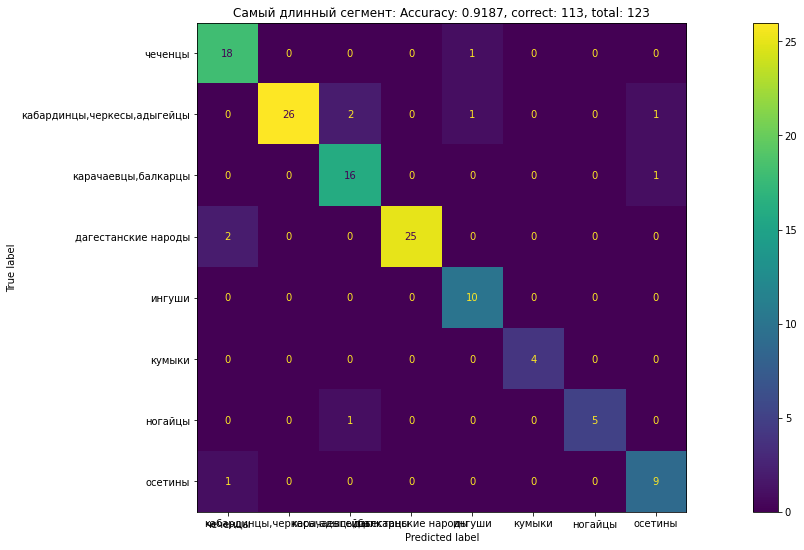

Сумма IBD до класса: Accuracy: 0.9431, correct: 116, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.90      1.00      0.95        19
кабардинцы,черкесы,адыгейцы       1.00      0.90      0.95        30
        карачаевцы,балкарцы       0.84      0.94      0.89        17
        дагестанские народы       1.00      0.93      0.96        27
                     ингуши       0.91      1.00      0.95        10
                     кумыки       1.00      1.00      1.00         4
                    ногайцы       1.00      0.83      0.91         6
                    осетины       0.91      1.00      0.95        10

                   accuracy                           0.94       123
                  macro avg       0.95      0.95      0.95       123
               weighted avg       0.95      0.94      0.94       123



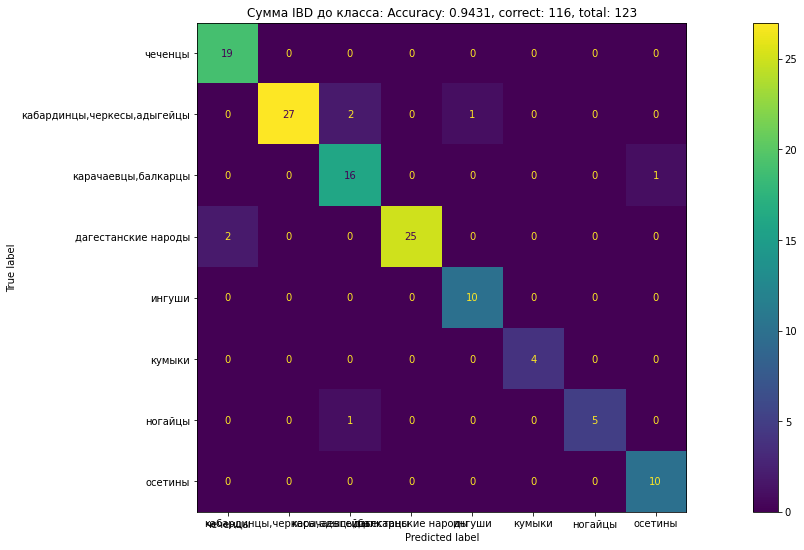

Сумма IBD до класса на ребро: Accuracy: 0.8862, correct: 109, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.82      0.95      0.88        19
кабардинцы,черкесы,адыгейцы       1.00      0.83      0.91        30
        карачаевцы,балкарцы       0.83      0.88      0.86        17
        дагестанские народы       1.00      0.89      0.94        27
                     ингуши       0.69      0.90      0.78        10
                     кумыки       1.00      1.00      1.00         4
                    ногайцы       0.83      0.83      0.83         6
                    осетины       0.82      0.90      0.86        10

                   accuracy                           0.89       123
                  macro avg       0.87      0.90      0.88       123
               weighted avg       0.90      0.89      0.89       123



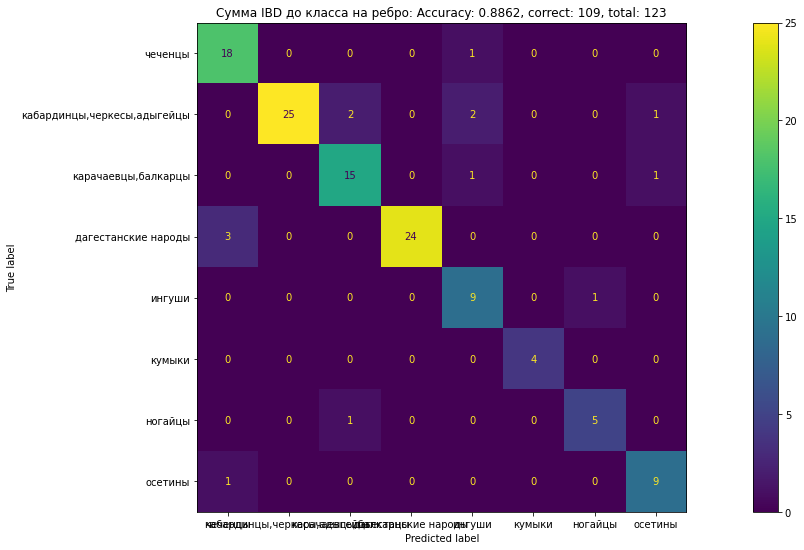

In [6]:
valshare = 0.2
testshare = 0.2
#print(ncls)
#remember that ncls are starting from 0 and consecutive
#also somewhere we should check connectivity, e.g. if test node have connections with train tree at all

permt = bh.getrandompermutation(ncls, rng)
#print(permt)
trainnodeclasses, valnodeclasses, testnodeclasses = bh.dividetrainvaltest(ncls, valshare, testshare, permt)
#here subdivision does not change translation array as we still have the same graph,
#but will compute features only for test nodes and based on links to trainnodeclasses only
trainvalnodeclasses = {}
for c in trainnodeclasses:
    trainvalnodeclasses[c] = np.concatenate((trainnodeclasses[c], valnodeclasses[c]))

print("train|val|test distribution")
for c in trainnodeclasses:
    print(c, ":", trainnodeclasses[c].shape[0], ":", valnodeclasses[c].shape[0], ":", testnodeclasses[c].shape[0])
    #print(c, ":", trainnodeclasses[c], ":", valnodeclasses[c], ":", testnodeclasses[c])

trainnodes, valnodes, testnodes = bh.gettrainvaltestnodes(trainnodeclasses, valnodeclasses, testnodeclasses)
print("train nodes:", trainnodes.shape[0])
print("val nodes:", valnodes.shape[0])
print("test nodes:", testnodes.shape[0])

bh.checkpartition(grph, trainnodeclasses, valnodeclasses, testnodeclasses, details=True, trns=trns)
testlabels = labels[testnodes]

start = time.time()
#featuredict = bh.getfeatures(grph, testnodes, trainnodeclasses, labeldict, pairs, trns )
featuredict = bh.getfeatures(grph, grph.nodes, trainvalnodeclasses, labeldict, pairs, trns )
print(f"features collected in {time.time()-start} seconds\n")

simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    #predictedlabels = np.array([ prediction[node] for node in testnodes])
    predictedlabels = prediction[testnodes]
    title = featuredict[feature]["comment"]
    bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), title)


# Наиболее уверенный классификатор для 20%

Классификация наиболее уверенным классификатором.: Accuracy: 0.8780, correct: 108, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.72      0.95      0.82        19
кабардинцы,черкесы,адыгейцы       1.00      0.77      0.87        30
        карачаевцы,балкарцы       0.85      1.00      0.92        17
        дагестанские народы       1.00      0.81      0.90        27
                     ингуши       0.83      1.00      0.91        10
                     кумыки       1.00      0.75      0.86         4
                    ногайцы       1.00      1.00      1.00         6
                    осетины       0.75      0.90      0.82        10

                   accuracy                           0.88       123
                  macro avg       0.89      0.90      0.89       123
               weighted avg       0.90      0.88      0.88       123



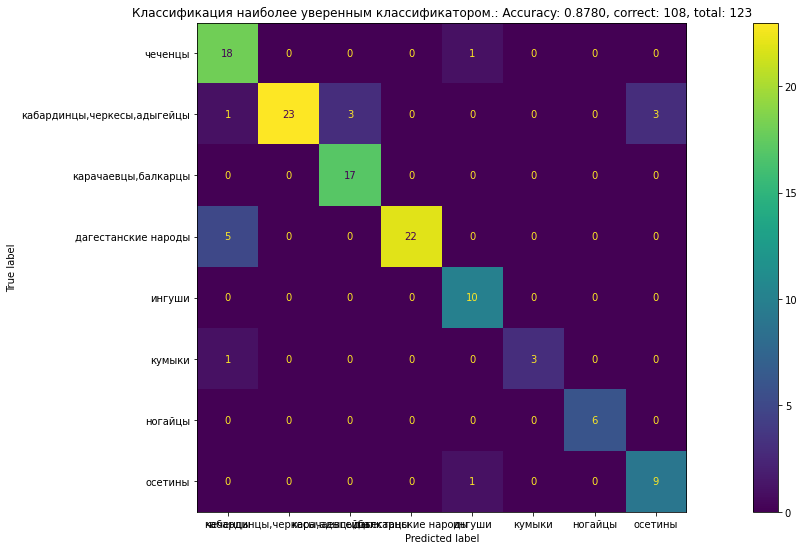

In [14]:
featureweights = {
    'IbdSumPerEdge': 0, 
    'IbdSum': 1, 
    'LongestIbd': 1, 
    'SegmentCountWMult': 0, 
    'SegmentCountPerClassize': 1, 
    'SegmentCount': 0}

#this is useful for the case where no second-best class is available, so several classifiers have infinite confidence
featurepriority = [
    "IbdSum",
    "LongestIbd",
    "SegmentCountWMult",
    "SegmentCountPerClassize",        
    "SegmentCount",    
    "IbdSumPerEdge"]

mostconfident = bh.get_most_confident_prediction(featuredict, featureweights, featurepriority)
predictedlabels = mostconfident[testnodes]
bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), "Классификация наиболее уверенным классификатором.")



{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0
{'IbdSumPerEdge': 0, 'IbdSum': 0.2, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.30000000000000004, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.4, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.5, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.6, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassi

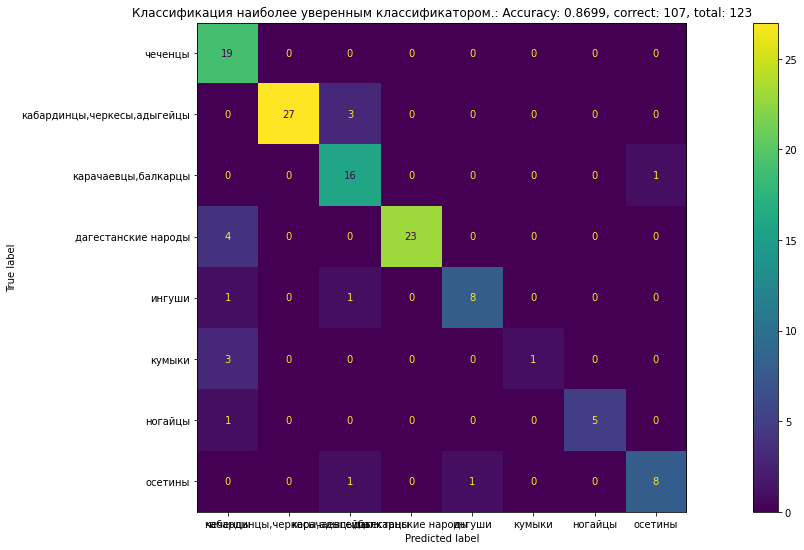

In [18]:
#search for the best parameter combination
#may take hours
featureweightrange = {
    "SegmentCount": [0],
    "SegmentCountPerClassize": [0],
    "SegmentCountWMult": [1],    
    "LongestIbd": np.arange(0.1,1.5,0.1),
    "IbdSum": np.arange(0.1,1.5,0.1),    
    "IbdSumPerEdge": [0]
}

#featureweightrange = {
#    "SegmentCount": [0],
#    "SegmentCountPerClassize": [1.38],
#    "SegmentCountWMult": [0],
#    "LongestIbd": [1],
#    "IbdSum": [0.41],
#    "IbdSumPerEdge": [0]
#}


#we will search for best weights on train nodes and then apply most confident classifier with these weights to test nodes
trainvalnodes = np.concatenate((trainnodes, valnodes))
trainvallabels = labels[trainvalnodes] 

bestweights, bestaccuracy = bh.search_best_weights(featuredict, featureweightrange, featurepriority, trainvallabels, trainvalnodes, True)
print(bestweights, bestaccuracy)

mostconfident = bh.get_most_confident_prediction(featuredict, bestweights, featurepriority)
bh.show_prediction(testlabels, mostconfident[testnodes], labeldict.keys(), "Классификация наиболее уверенным классификатором.")
#bh.show_prediction(trainlabels, mostconfident[trainnodes], labeldict.keys(), "Классификация наиболее уверенным классификатором.")

In [19]:
#repeat for new subdivision
#todo: change to f1_macro
#todo: add simple heuristics averaging
itercount = 100
totalaccr = 0
for itr in range(itercount):
    permt = bh.getrandompermutation(ncls, rng)
    #print(permt)
    trainnodeclasses, valnodeclasses, testnodeclasses = bh.dividetrainvaltest(ncls, valshare, testshare, permt)
    #here subdivision does not change translation array as we still have the same graph,
    #but will compute features only for test nodes and based on links to trainnodeclasses only

    #print("train:", trainnodeclasses)
    #print("val:", valnodeclasses)
    #print("test:", testnodeclasses)
    
    
    #when it will be neccessary to 
    #print("train|test distribution")
    #for c in trainnodeclasses:
    #    print(c, ":", trainnodeclasses[c].shape[0], ":", valnodeclasses[c].shape[0], ":", testnodeclasses[c].shape[0])

    trainnodes, valnodes, testnodes = bh.gettrainvaltestnodes(trainnodeclasses, valnodeclasses, testnodeclasses)
    #print("train nodes:", trainnodes.shape[0])
    #print("test nodes:", testnodes.shape[0])
    trainvalnodes = np.concatenate((trainnodes,valnodes))

    testlabels = labels[testnodes]
    trainvallabels = labels[trainvalnodes] 

    start = time.time()
    featuredict = bh.getfeatures(grph, grph.nodes, trainnodeclasses, labeldict, pairs, trns )
    #print(f"features collected in {time.time()-start} seconds\n")

    bestweights, bestaccuracy = bh.search_best_weights(featuredict, featureweightrange, featurepriority, trainvallabels, trainvalnodes, False)
    print("iter", itr)
    print(bestweights, bestaccuracy)
    mostconfident = bh.get_most_confident_prediction(featuredict, bestweights, featurepriority)
    accr = np.sum(testlabels == mostconfident[testnodes])/testnodes.shape[0]
    totalaccr += accr
    print(f" Accuracy: {accr:.4f}, correct: {np.sum(testlabels == mostconfident[testnodes])}, total: {testnodes.shape[0]}")
    
    #bh.show_prediction(testlabels, mostconfident[testnodes], labeldict.keys(), "Классификация наиболее уверенным классификатором.")
    #break
print("average accuracy:", totalaccr/itercount)

iter 0
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.8920570264765784
 Accuracy: 0.8699, correct: 107, total: 123
iter 1
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.8, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.8940936863543788
 Accuracy: 0.9106, correct: 112, total: 123
iter 2
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 1.0, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.9103869653767821
 Accuracy: 0.9187, correct: 113, total: 123
iter 3
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 1.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.9144602851323829
 Accuracy: 0.8374, correct: 103, total: 123
iter 4
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.9022403258655805
 Accuracy: 0.8943, correct: 110, total: 123
iter 5
{'I